## 🔹 Paso 0: Preparación

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


## 🔹 Paso 1: Carga del Dataset

In [2]:

# Reemplaza con tu archivo/dataset
data = pd.read_csv("../1_data/dataset_obesity_clean.csv", index_col=0)
display(data.head())


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## 🔹 Paso 2: Preprocesamiento de Datos

In [3]:

categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('NObeyesdad')
data_encoded = pd.get_dummies(data, columns=categorical_cols, dummy_na=False)
df_processed = data_encoded.copy()


## 🔹 Paso 3: Ingeniería de Características

In [4]:

df_processed['BMI'] = df_processed['Weight'] / (df_processed['Height'] ** 2)

X = df_processed.drop(columns=['NObeyesdad'])
y = df_processed['NObeyesdad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
importance_df.sort_values(by='importance', ascending=False).head(10)


,feature,importance
31,BMI,0.323169
2,Weight,0.179640
0,Age,0.057949
3,FCVC,0.057595
1,Height,0.051101
8,Gender_Female,0.038305
4,NCP,0.036130
9,Gender_Male,0.031118
7,TUE,0.027389
5,CH2O,0.025054


## 🔹 Paso 4: Nuevas Características Basadas en Importancia

In [5]:

df_processed['Weight_Age_Ratio'] = df_processed['Weight'] / df_processed['Age']
df_processed['FAF_TUE_Interaction'] = df_processed['FAF'] * df_processed['TUE']


## 🔹 Paso 5: División del Dataset (Train/Val/Test)

In [6]:

X = df_processed.drop(columns=['NObeyesdad'])
y = df_processed['NObeyesdad']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=84, stratify=y_temp)


## 🔹 Paso 6: Escalamiento y Codificación

In [7]:

numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI', 'Weight_Age_Ratio', 'FAF_TUE_Interaction']
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_val_scaled = scaler.transform(X_val[numerical_cols])
X_test_scaled = scaler.transform(X_test[numerical_cols])

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)
y_test_encoded = encoder.transform(y_test)

train_df = pd.DataFrame(X_train_scaled, columns=numerical_cols)
train_df['NObeyesdad'] = y_train_encoded
val_df = pd.DataFrame(X_val_scaled, columns=numerical_cols)
val_df['NObeyesdad'] = y_val_encoded
test_df = pd.DataFrame(X_test_scaled, columns=numerical_cols)
test_df['NObeyesdad'] = y_test_encoded


## 🔹 Paso 7: Entrenamiento y Evaluación de Modelos

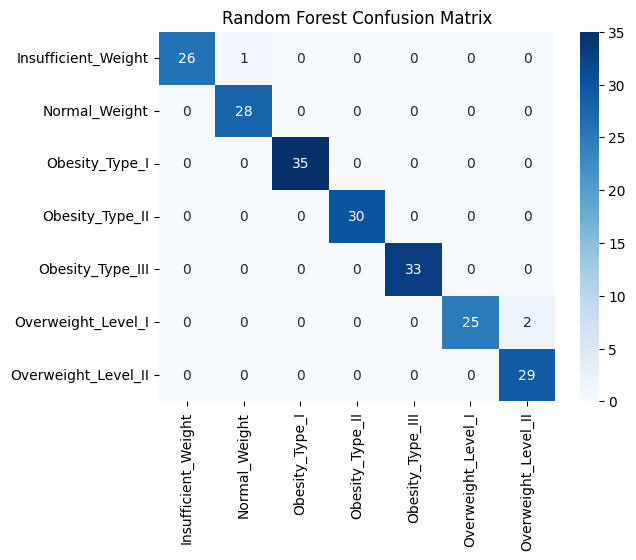

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


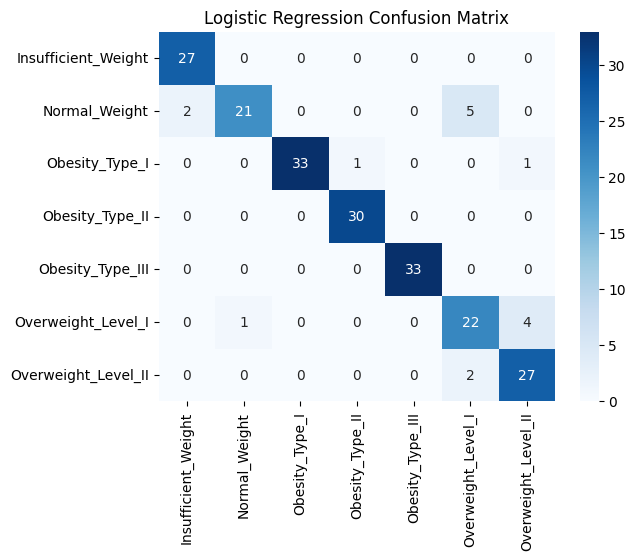

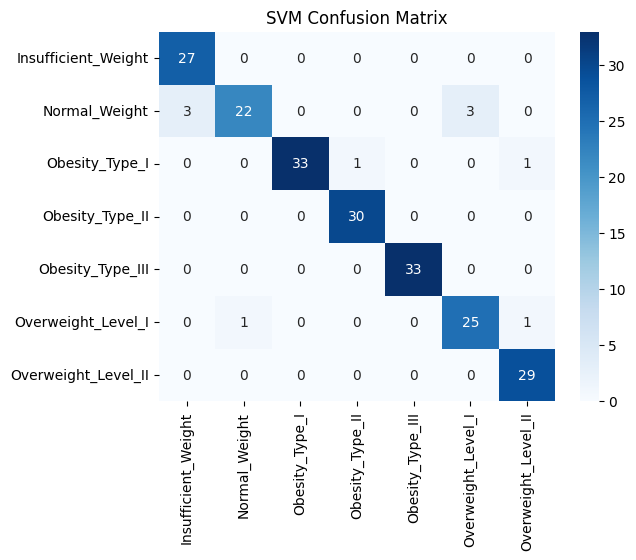

In [8]:

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42),
    "SVM": SVC(random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(train_df.drop(columns=['NObeyesdad']), train_df['NObeyesdad'])
    y_pred_val = model.predict(val_df.drop(columns=['NObeyesdad']))
    
    results[name] = {
        "Accuracy": accuracy_score(val_df['NObeyesdad'], y_pred_val),
        "Precision": precision_score(val_df['NObeyesdad'], y_pred_val, average='weighted'),
        "Recall": recall_score(val_df['NObeyesdad'], y_pred_val, average='weighted'),
        "F1-Score": f1_score(val_df['NObeyesdad'], y_pred_val, average='weighted'),
        "Confusion Matrix": confusion_matrix(val_df['NObeyesdad'], y_pred_val),
    }

    sns.heatmap(results[name]["Confusion Matrix"], annot=True, fmt="d", cmap="Blues",
                xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.show()


## 🔹 Paso 8: Tuning de Hiperparámetros (Random Forest)

In [9]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(train_df.drop(columns=['NObeyesdad']), train_df['NObeyesdad'])

best_rf_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)


Mejores hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


## 🔹 Paso 9: Evaluación Final en Test Set

In [10]:

y_pred_test = best_rf_model.predict(test_df.drop(columns=['NObeyesdad']))
test_accuracy = accuracy_score(test_df['NObeyesdad'], y_pred_test)
print(f"Precisión final en test: {test_accuracy:.4f}")


Precisión final en test: 0.9904


In [11]:
import joblib
joblib.dump(best_rf_model, 'modelo_rf.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

In [14]:
# %%
import gradio as gr
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib
# %%
# Suponiendo que ya tienes el modelo entrenado, el scaler y el encoder guardados
# Guarda tu modelo, scaler y encoder así:
# joblib.dump(best_rf_model, 'modelo_rf.pkl')
# joblib.dump(scaler, 'scaler.pkl')
# joblib.dump(encoder, 'encoder.pkl')

# Cargar modelo, scaler y encoder
model = joblib.load("modelo_rf.pkl")
scaler = joblib.load("scaler.pkl")
encoder = joblib.load("encoder.pkl")
# %%
# Función para predecir
def predecir_obesidad(Age, Height, Weight, FCVC, NCP, CH2O, FAF, TUE):
    BMI = Weight / (Height ** 2)
    Weight_Age_Ratio = Weight / Age
    FAF_TUE_Interaction = FAF * TUE

    features = np.array([[Age, Height, Weight, FCVC, NCP, CH2O, FAF, TUE, BMI, Weight_Age_Ratio, FAF_TUE_Interaction]])
    features_scaled = scaler.transform(features)
    
    prediction = model.predict(features_scaled)
    clase = encoder.inverse_transform(prediction)
    return f"Clasificación: {clase[0]}"
# %%
# Interfaz Gradio
interface = gr.Interface(
    fn=predecir_obesidad,
    inputs=[
        gr.Number(label="Edad"),
        gr.Number(label="Estatura (m)"),
        gr.Number(label="Peso (kg)"),
        gr.Slider(1, 3, step=0.1, label="Frecuencia de consumo de vegetales (FCVC)"),
        gr.Slider(1, 4, step=1, label="Número de comidas (NCP)"),
        gr.Slider(1, 3, step=0.1, label="Consumo de agua (CH2O)"),
        gr.Slider(0, 3, step=0.1, label="Actividad física (FAF)"),
        gr.Slider(0, 2, step=0.1, label="Uso de tecnología (TUE)")
    ],
    outputs="text",
    title="Clasificador de Obesidad",
    description="Ingresa tus datos para predecir la categoría de obesidad según el modelo entrenado"
)
# %%
interface.launch()

ModuleNotFoundError: No module named 'gradio'